In [1]:
# Mount google drive

from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import json
import os
import glob
from lxml import etree

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


Mounted at /content/drive


In [2]:
# File paths
main_directory = "/content/drive/My Drive/266_NLP/final project/"
model_directory = "/content/drive/My Drive/266_NLP/final project/models/all-MiniLM-L6-v2/"
output_csv = "/content/drive/My Drive/266_NLP/final project/uspto_patents_cpc_metadata.csv"


In [ ]:
import os
import glob
from lxml import etree
import json
import pandas as pd

def extract_all_claims(root):
    claims = root.findall(".//claims/claim")
    all_claims = []
    for claim in claims:
        parts = claim.findall(".//claim-text")
        claim_text = " ".join(p.text.strip() for p in parts if p.text)
        all_claims.append(claim_text)  # Removed claim_number
    return all_claims

def extract_patent_metadata(xml_path):
    try:
        tree = etree.parse(xml_path)
        root = tree.getroot()

        def gettext(xpath):
            el = root.find(xpath)
            return el.text.strip() if el is not None and el.text else None

        def getalltext(xpath):
            els = root.findall(xpath)
            return [el.text.strip() for el in els if el is not None and el.text]

        # Fetch all parts together
        sections = getalltext(".//classification-cpc/section")
        classes = getalltext(".//classification-cpc/class")
        subclasses = getalltext(".//classification-cpc/subclass")
        main_groups = getalltext(".//classification-cpc/main-group")
        subgroups = getalltext(".//classification-cpc/subgroup")

        # Zip CPC levels to produce full identifiers
        cpc_entries = list(zip(sections, classes, subclasses, main_groups, subgroups))

        def safe_join(*parts, sep=""):
            return sep.join(p for p in parts if p)

        metadata = {
            "file": os.path.basename(xml_path),
            "publication_number": gettext(".//publication-reference/document-id/doc-number"),
            "application_number": gettext(".//application-reference/document-id/doc-number"),
            "publication_date": gettext(".//publication-reference/document-id/date"),
            "application_date": gettext(".//application-reference/document-id/date"),
            "invention_title": gettext(".//invention-title"),

            # Construct full identifiers
            "section": sorted(set(sections)),
            "class": sorted(set(safe_join(s, c) for s, c, _, _, _ in cpc_entries if s and c)),
            "subclass": sorted(set(safe_join(s, c, sc) for s, c, sc, _, _ in cpc_entries if s and c and sc)),
            "main_group": sorted(set(safe_join(s, c, sc, mg) for s, c, sc, mg, _ in cpc_entries if s and c and sc and mg)),
            "subgroup": sorted(set(safe_join(s, c, sc, mg, "-" + sg) for s, c, sc, mg, sg in cpc_entries if s and c and sc and mg and sg)),

            "country": gettext(".//country"),
            "abstract": gettext(".//abstract/p"),
            "assignee": gettext(".//assignees/assignee/addressbook/orgname"),
            "inventor_1": gettext(".//inventors/inventor[1]/addressbook/last-name"),
            "inventor_2": gettext(".//inventors/inventor[2]/addressbook/last-name"),
            "claims": extract_all_claims(root),
        }

        return metadata
    except Exception as e:
        return {"file": os.path.basename(xml_path), "error": str(e)}


def extract_from_directory(directory):
    xml_files = glob.glob(os.path.join(directory, "*.xml"))
    print(f"Found {len(xml_files)} XML files in {directory}")
    return [extract_patent_metadata(path) for path in xml_files]

if not os.path.exists(output_csv):

  # Extract
  records = extract_from_directory(directory)

  # Save CSV
  df = pd.DataFrame(records)
  df["section"] = df["section"].apply(lambda x: ",".join(sorted(set(x))) if isinstance(x, list) else x)
  df["claims"] = df["claims"].apply(lambda x: " ".join(x) if isinstance(x, list) else "")
  df["combined_text"] = (
      df["invention_title"].fillna("") + " " +
      df["abstract"].fillna("") + " " +
      df["claims"]
  ).str.lower()

  df.to_csv(output_csv, index=False)

  print(f"Extracted {len(records)} files. Saved to JSON and CSV.")
  del records

In [3]:
df_all=pd.read_csv(main_directory + "uspto_patents_cpc_metadata.csv")
df_all = df_all.dropna(subset=['section'])
df_cleaned, test_df = train_test_split(df_all, test_size=0.20, random_state=42)

df_cleaned = df_cleaned.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

df_cleaned.head()



,file,publication_number,application_number,publication_date,application_date,invention_title,section,class,subclass,main_group,subgroup,country,assignee,inventor_1,abstract,claims,combined_text
0,doc_1371.xml,20250195720,18544429,20250619,20231219,SILICONE OIL IN WATER INJECTABLE FILLER COMPOS...,"A,C","['A61', 'C08']","['A61L', 'C08L']","['A61L2300', 'A61L2400', 'A61L2430', 'A61L27',...","['A61L2300-402', 'A61L2300-428', 'A61L2400-06'...",US,NaN,Mezzancello,A silicone oil in water composition that is an...,1. An injectable filler composition that can b...,silicone oil in water injectable filler compos...
1,doc_8236.xml,20250202385,19066028,20250619,20250227,"CONTROL APPARATUS OF VIBRATION ACTUATOR, CONTR...",H,['H02'],['H02N'],['H02N2'],['H02N2-142'],US,NaN,MORITA,A control unit of a control apparatus for a vi...,1. A control apparatus of a vibration actuator...,"control apparatus of vibration actuator, contr..."
2,doc_17822.xml,12335647,18529767,20250617,20231205,Time-resolving computational image sensor arch...,H,['H04'],['H04N'],['H04N25'],"['H04N25-745', 'H04N25-75', 'H04N25-771']",US,"Samsung Electronics Co., Ltd.",Wang,A pixel for an image sensor includes a photon ...,1. A method for processing imaging data from a...,time-resolving computational image sensor arch...
3,doc_9647.xml,20250203796,18981576,20250619,20241215,Cover for Electrical Devices,H,['H05'],['H05K'],['H05K5'],"['H05K5-0217', 'H05K5-03']",US,NaN,JADE,The present invention provides a cover assembl...,1. A cover assembly (100) for an electrical de...,cover for electrical devices the present inven...
4,doc_5623.xml,20250199775,18543282,20250619,20231218,DESIGN TIME SMART ANALYZER AND RUNTIME SMART H...,G,['G06'],['G06F'],['G06F8'],"['G06F8-34', 'G06F8-35']",US,"UiPath, Inc.",GRIGORE,A design time smart analyzer and a runtime sma...,1. A non-transitory computer-readable medium s...,design time smart analyzer and runtime smart h...


In [4]:
import numpy as np
from sentence_transformers import SentenceTransformer

if not os.path.exists(model_directory + "all-MiniLM-L6-v2_embeddings_df_cleaned.npy"):
  # Initialize embedding model
  embedder = SentenceTransformer("all-MiniLM-L6-v2")
  #Create embeddings
  embeddings = embedder.encode(df_cleaned["combined_text"].tolist())
  np.save(model_directory + "all-MiniLM-L6-v2_embeddings_df_cleaned.npy", embeddings)
else:
    print("Embeddings already exist for df_cleaned split.")
    embeddings = np.load(model_directory + "all-MiniLM-L6-v2_embeddings_df_cleaned.npy")

print(embeddings.shape)

Embeddings already exist for df_cleaned split.
(13746, 384)


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

# Step 1: Preprocess labels (multi-label binarization)
# The filtering for missing 'section' values was already done when creating df_cleaned from df_all
# No need to dropna again here.

# Split section into list (if it's a comma-separated string)
df_cleaned['section_list'] = df_cleaned['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Binarize multi-label output
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y = mlb.fit_transform(df_cleaned["section_list"])


# Step 2: Train-test split
# Since embeddings were created from df_cleaned (after the initial split and dropping missing sections),
# we can use the index of this df_cleaned directly as it corresponds to the embeddings.
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, test_size=0.5, random_state=42
)

# Step 3: Train a One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)
print("Multi-label Section Classification Report (OneVsRestClassifier) on df_cleaned split without finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Multi-label Section Classification Report (OneVsRestClassifier) on df_cleaned split without finetuned embeddings:

              precision    recall  f1-score   support

           A       0.91      0.32      0.48      1312
           B       0.91      0.12      0.22      1214
           C       0.82      0.33      0.47       771
           D       0.00      0.00      0.00        49
           E       1.00      0.01      0.01       199
           F       1.00      0.06      0.11       500
           G       0.83      0.64      0.72      2445
           H       0.89      0.60      0.71      2415
           Y       1.00      0.04      0.08        47

   micro avg       0.86      0.43      0.58      8952
   macro avg       0.82      0.24      0.31      8952
weighted avg       0.88      0.43      0.54      8952
 samples avg       0.52      0.48      0.49      8952



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
# Use a logistic regression based classifier
from sklearn.linear_model import LogisticRegression

clf = OneVsRestClassifier(LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
))
clf.fit(X_train, y_train)

# ------------------------------------------------
# STEP 5: Predict & Evaluate
# ------------------------------------------------

y_pred = clf.predict(X_test)


# Classification report
print("Multi-label LogisticRegression Section Classification Report on df_cleaned split without finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))



Multi-label LogisticRegression Section Classification Report on df_cleaned split without finetuned embeddings:
              precision    recall  f1-score   support

           A       0.65      0.86      0.74      1312
           B       0.47      0.84      0.60      1214
           C       0.57      0.92      0.70       771
           D       0.19      0.82      0.31        49
           E       0.21      0.80      0.33       199
           F       0.34      0.86      0.49       500
           G       0.75      0.85      0.79      2445
           H       0.74      0.83      0.78      2415
           Y       0.02      0.30      0.04        47

   micro avg       0.56      0.85      0.67      8952
   macro avg       0.44      0.79      0.53      8952
weighted avg       0.64      0.85      0.72      8952
 samples avg       0.65      0.88      0.71      8952



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


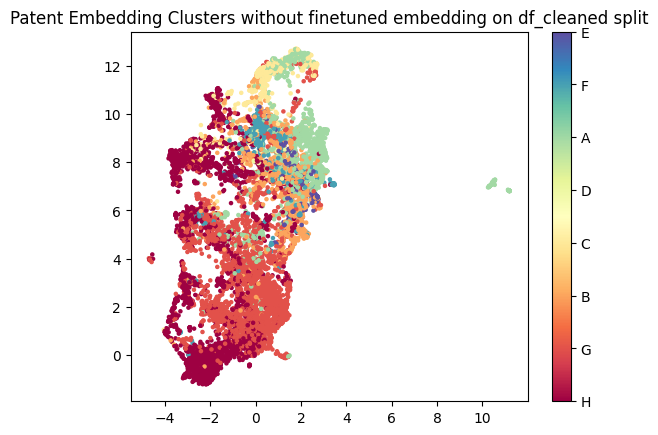

In [7]:
import umap
import matplotlib.pyplot as plt

valid_sections = list("ABCDEFGHY")
df_cleaned_tmp = df_cleaned[df_cleaned["section"].isin(valid_sections)]

reducer = umap.UMAP(n_neighbors=15, random_state=42)
# Compute UMAP projection only on embeddings corresponding to df_cleaned
proj = reducer.fit_transform(embeddings[df_cleaned_tmp.index])

# Define labels for coloring the scatter plot
labels = df_cleaned_tmp["section"]

# Map string labels to numerical values
unique_labels = labels.unique()
label_map = {label: i for i, label in enumerate(unique_labels)}
numerical_labels = labels.map(label_map)


plt.scatter(proj[:,0], proj[:,1], c=numerical_labels, cmap='Spectral', s=5)
plt.title("Patent Embedding Clusters without finetuned embedding on df_cleaned split")
# Add a colorbar to show the mapping of colors to sections
cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.show()

In [8]:
import numpy as np
from sentence_transformers import SentenceTransformer

if not os.path.exists(model_directory + "all-MiniLM-L6-v2_embeddings_test_df.npy"):
  # Initialize embedding model
  embedder = SentenceTransformer("all-MiniLM-L6-v2")
  #Create embeddings
  embeddings = embedder.encode(test_df["combined_text"].tolist())
  np.save(model_directory + "all-MiniLM-L6-v2_embeddings_test_df.npy", embeddings)
else:
    print("Embeddings already exist for test_df split.")
    embeddings = np.load(model_directory + "all-MiniLM-L6-v2_embeddings_test_df.npy")

print(embeddings.shape)

Embeddings already exist for test_df split.
(3437, 384)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

# Step 1: Preprocess labels (multi-label binarization)

# Split section into list (if it's a comma-separated string)
test_df['section_list'] = test_df['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Binarize multi-label output
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y = mlb.fit_transform(test_df["section_list"])


# Step 2: Train-test split
# Since embeddings were created from df_cleaned (after the initial split and dropping missing sections),
# we can use the index of this df_cleaned directly as it corresponds to the embeddings.
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, test_size=0.5, random_state=42
)

# Step 3: Train a One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)
print("Multi-label Section Classification Report (OneVsRestClassifier) on test_df split without finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Multi-label Section Classification Report (OneVsRestClassifier) on test_df split without finetuned embeddings:

              precision    recall  f1-score   support

           A       0.93      0.26      0.41       314
           B       0.94      0.05      0.09       314
           C       0.88      0.23      0.36       186
           D       0.00      0.00      0.00        19
           E       0.00      0.00      0.00        49
           F       1.00      0.05      0.09       109
           G       0.75      0.61      0.67       599
           H       0.88      0.54      0.67       634
           Y       0.00      0.00      0.00        18

   micro avg       0.82      0.38      0.52      2242
   macro avg       0.60      0.19      0.25      2242
weighted avg       0.83      0.38      0.47      2242
 samples avg       0.47      0.42      0.43      2242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [10]:
# Use a logistic regression based classifier
from sklearn.linear_model import LogisticRegression

clf = OneVsRestClassifier(LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
))
clf.fit(X_train, y_train)

# ------------------------------------------------
# STEP 5: Predict & Evaluate
# ------------------------------------------------

y_pred = clf.predict(X_test)


# Classification report
print("Multi-label LogisticRegression Section Classification Report on test_df split without finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Multi-label LogisticRegression Section Classification Report on test_df split without finetuned embeddings:
              precision    recall  f1-score   support

           A       0.63      0.86      0.73       314
           B       0.44      0.82      0.58       314
           C       0.55      0.95      0.70       186
           D       0.35      0.63      0.45        19
           E       0.21      0.76      0.33        49
           F       0.26      0.73      0.38       109
           G       0.70      0.83      0.76       599
           H       0.73      0.85      0.79       634
           Y       0.00      0.00      0.00        18

   micro avg       0.56      0.83      0.67      2242
   macro avg       0.43      0.71      0.52      2242
weighted avg       0.61      0.83      0.70      2242
 samples avg       0.64      0.86      0.70      2242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
# Balancing classes
import os
import pandas as pd
from itertools import combinations
import random
from collections import defaultdict

build_df_pairs = False

if os.path.exists(main_directory + "df_pairs.csv"):
    print("Loading existing df_pairs.csv ...")
    df_pairs = pd.read_csv(main_directory + "df_pairs.csv")
else:
    print("df_pairs.csv does not exist. Building...")
    build_df_pairs = True

if build_df_pairs:
    # ------------------------------------------------------
    # STEP 1 — Group publications by labels
    # ------------------------------------------------------
    label_to_pubs = defaultdict(list)
    all_pubs = set()

    for row in df_cleaned.itertuples(index=False):
        pub_number = row.publication_number
        all_pubs.add(pub_number)
        for label in row.section.split(','):
            label_to_pubs[label.strip()].append(pub_number)

    print("Label → # publications mapping:")
    for label, pubs in label_to_pubs.items():
        print(f"Label {label}: {len(pubs)} publications")

    # ------------------------------------------------------
    # STEP 2 — Generate positive pairs, balanced per label
    # ------------------------------------------------------
    max_pos_pairs_per_class = 2000
    positive_pairs = []

    for label, pub_list in label_to_pubs.items():
        pub_list = sorted(set(pub_list))
        pairs = list(combinations(pub_list, 2))

        random.shuffle(pairs)
        pairs = pairs[:max_pos_pairs_per_class]

        for a, b in pairs:
            positive_pairs.append({
                "pub1": a,
                "pub2": b,
                "label": 1,
                "matched_class": label
            })

        print(f"Label {label}: Kept {len(pairs)} positive pairs")

    print(f"\nTotal positive pairs: {len(positive_pairs)}")

    # ------------------------------------------------------
    # STEP 3 — Generate negative pairs per label
    # ------------------------------------------------------
    negative_pairs = []
    max_neg_pairs_per_class = 2000

    for label, positive_pubs in label_to_pubs.items():
        pubs_not_in_label = list(all_pubs - set(positive_pubs))

        pairs_for_label = []
        for pub in positive_pubs:
            # If there are no pubs outside this label, skip
            if not pubs_not_in_label:
                continue

            # Sample a few negatives for this pub
            num_neg_samples = min(5, len(pubs_not_in_label))
            sampled_negatives = random.sample(pubs_not_in_label, num_neg_samples)

            for neg_pub in sampled_negatives:
                a, b = sorted([pub, neg_pub])
                pairs_for_label.append({
                    "pub1": a,
                    "pub2": b,
                    "label": 0,
                    "matched_class": label
                })

        # Keep max_neg_pairs_per_class for this label
        random.shuffle(pairs_for_label)
        pairs_for_label = pairs_for_label[:max_neg_pairs_per_class]

        negative_pairs.extend(pairs_for_label)

        print(f"Label {label}: Kept {len(pairs_for_label)} negative pairs")

    print(f"\nTotal negative pairs: {len(negative_pairs)}")

    # ------------------------------------------------------
    # STEP 4 — Balance positive and negative pair totals
    # ------------------------------------------------------

    max_samples = min(len(positive_pairs), len(negative_pairs))

    balanced_positive = positive_pairs[:max_samples]
    balanced_negative = negative_pairs[:max_samples]

    all_pairs = balanced_positive + balanced_negative
    random.shuffle(all_pairs)

    # ------------------------------------------------------
    # STEP 5 — Save pairs DataFrame
    # ------------------------------------------------------

    df_pairs = pd.DataFrame(all_pairs)
    print(f"\nBalanced pair dataframe with {len(df_pairs)} rows.")

    df_pairs.to_csv(main_directory + 'df_pairs.csv', index=False)
    print("✅ df_pairs.csv saved!")


Loading existing df_pairs.csv ...


In [12]:
import gc
# Uncomment to free up resources, if enough memory is not available
# if embeddings is not None:
#     del embeddings
# if X_train is not None:
#     del X_train
# if X_test is not None:
#     del X_test
# if y_train is not None:
#     del y_train
# if y_test is not None:
#     del y_test
# if clf is not None:
#     del clf
# if y_pred is not None:
#     del y_pred

# if build_df_pairs:
#   if positive_pairs is not None:
#       del positive_pairs
#   if negative_pairs is not None:
#       del negative_pairs
#   if balanced_positive is not None:
#       del balanced_positive
#   if balanced_negative is not None:
#       del balanced_negative
#       del all_pairs
  # if df_sample is not None:
  #     del df_sample

gc.collect()

44948

In [13]:
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader

if os.path.exists(model_directory + "fine_tuned_patent_model_all-MiniLM-L6-v2"):
    print("Fine-tuned model already exists. Loading...")
    model = SentenceTransformer(model_directory + "fine_tuned_patent_model_all-MiniLM-L6-v2")
else:

  # Extract the combined_text field corresponding to the publication from df_cleaned for publications in df_pairs
  df_pairs["pub1_text"] = df_pairs["pub1"].apply(lambda x: df_cleaned[df_cleaned["publication_number"] == str(x)]["combined_text"].values[0])
  df_pairs["pub2_text"] = df_pairs["pub2"].apply(lambda x: df_cleaned[df_cleaned["publication_number"] == str(x)]["combined_text"].values[0])

  # del df_cleaned
  # gc.collect()


  # Build InputExample list
  train_examples = []

  for _, row in df_pairs.iterrows():
      text1 = row["pub1_text"]
      text2 = row["pub2_text"]
      label = float(row["label"])

      train_examples.append(InputExample(
          texts=[text1, text2],
          label=label
      ))

  # del df_pairs
  # gc.collect()

  # ------------------------------------------------------------
  # Create DataLoader
  # ------------------------------------------------------------

  train_dataloader = DataLoader(
      train_examples,
      shuffle=True,
      batch_size=8
  )

  # ------------------------------------------------------------
  # Load Base Model
  # ------------------------------------------------------------

  # Good patent model options:
  # - "AI-Growth-Lab/PatentSBERTa"
  # - "intfloat/e5-base-v2"
  # - "all-MiniLM-L6-v2"

  #model_name = "AI-Growth-Lab/PatentSBERTa"
  #model_name = "intfloat/e5-base-v2"
  model_name = "all-MiniLM-L6-v2"
  model = SentenceTransformer(model_name)

  # ------------------------------------------------------------
  # Define Loss Function
  # ------------------------------------------------------------

  train_loss = losses.CosineSimilarityLoss(model)

  # ------------------------------------------------------------
  # Fine-Tune!
  # ------------------------------------------------------------

  model.fit(
      train_objectives=[(train_dataloader, train_loss)],
      epochs=2,
      warmup_steps=10,
      show_progress_bar=True
  )

  # ------------------------------------------------------------
  # Save Fine-Tuned Model
  # ------------------------------------------------------------

  model.save(model_directory+"fine_tuned_patent_model_all-MiniLM-L6-v2")
  print("Model fine-tuned and saved!")


Fine-tuned model already exists. Loading...


In [14]:
# Test quality of embeddings
# Get specific rows based on column publication_number
row1 = df_all[df_all['publication_number'].astype(str)=='20250200793']
row2= df_all[df_all['publication_number'].astype(str)=='20250200005']
row3= df_all[df_all['publication_number'].astype(str)=='20250201918']

text1=row1["combined_text"].values[0]
text2=row2["combined_text"].values[0]
text3=row3["combined_text"].values[0]

embedder = SentenceTransformer("all-MiniLM-L6-v2")

v1 = embedder.encode([text1])
v2 = embedder.encode([text2])
v3 = embedder.encode([text3])

similarity = cosine_similarity(v1, v2)
print(f"Similarity between patent1({row1['section'].values[0]}) and patent2({row2['section'].values[0]}):", similarity[0][0])

similarity = cosine_similarity(v1, v3)
print(f"Similarity between patent1({row1['section'].values[0]}) and patent3({row3['section'].values[0]}):", similarity[0][0])

similarity = cosine_similarity(v2, v3)
print(f"Similarity between patent2({row2['section'].values[0]}) and patent3({row3['section'].values[0]}):", similarity[0][0])
print('------------')
print('patent1(G):',text1[:500])
print('------------')
print('patent2(G):',text2[:500])
print('------------')
print('patent3(H):',text3[:500])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Similarity between patent1(G) and patent2(G): 0.3230428
Similarity between patent1(G) and patent3(H): 0.06629667
Similarity between patent2(G) and patent3(H): 0.026261734
------------
patent1(G): method and system for determining a camera position using a sequence of images depicting a traffic situation involving a plurality of moving vehicles recorded by a camera, a set of image event data are determined, where each image event data indicates a respective number of events related to the moving vehicles occurring during a respective imaging time interval. a set of incident event data are obtained from a database, where each incident event indicates a respective number of events occurring
------------
patent2(G): method and apparatus for free space management there is provided a method and apparatus for free space management in a distributed database. each datanode of the database is assigned a free space map to manage free space. when a datanode requires additional storage space, a new

In [15]:
# Test quality of embeddings
# Get specific rows based on column publication_number

embedder = SentenceTransformer(model_directory+"fine_tuned_patent_model_all-MiniLM-L6-v2")
v1 = embedder.encode([text1])
v2 = embedder.encode([text2])
v3 = embedder.encode([text3])

similarity = cosine_similarity(v1, v2)
print(f"Similarity between patent1({row1['section'].values[0]}) and patent2({row2['section'].values[0]}):", similarity[0][0])

similarity = cosine_similarity(v1, v3)
print(f"Similarity between patent1({row1['section'].values[0]}) and patent3({row3['section'].values[0]}):", similarity[0][0])

similarity = cosine_similarity(v2, v3)
print(f"Similarity between patent2({row2['section'].values[0]}) and patent3({row3['section'].values[0]}):", similarity[0][0])


Similarity between patent1(G) and patent2(G): 0.63560015
Similarity between patent1(G) and patent3(H): 0.63455075
Similarity between patent2(G) and patent3(H): -0.019925524


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [16]:
if not os.path.exists(model_directory + "all-MiniLM-L6-v2_embeddings_df_cleaned_tuned.npy"):
  # Initialize embedding model
  embedder = SentenceTransformer(model_directory + "fine_tuned_patent_model_all-MiniLM-L6-v2")
  #Create embeddings
  embeddings = embedder.encode(df_cleaned["combined_text"].tolist())
  np.save(model_directory + "all-MiniLM-L6-v2_embeddings_df_cleaned_tuned.npy", embeddings)
else:
    print("Tuned embeddings already exist for df_cleaned split.")
    embeddings = np.load(model_directory + "all-MiniLM-L6-v2_embeddings_df_cleaned_tuned.npy")


Tuned embeddings already exist for df_cleaned split.


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report


# Step 1: Preprocess labels (multi-label binarization)
# The filtering for missing 'section' values was already done when creating df_cleaned from df_all
# No need to dropna again here.
#embeddings = embedder.encode(df_cleaned["combined_text"].tolist())

# Split section into list (if it's a comma-separated string)
df_cleaned['section_list'] = df_cleaned['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Binarize multi-label output
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y = mlb.fit_transform(df_cleaned["section_list"])


# Step 2: Train-test split
# Since embeddings were created from df_cleaned (after the initial split and dropping missing sections),
# we can use the index of this df_cleaned directly as it corresponds to the embeddings.
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, test_size=0.5, random_state=42
)

# Step 3: Train a One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)
print("Multi-label Section Classification Report (OneVsRestClassifier) on df_cleaned split with finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

Multi-label Section Classification Report (OneVsRestClassifier) on df_cleaned split with finetuned embeddings:

              precision    recall  f1-score   support

           A       0.90      0.82      0.86      1312
           B       0.82      0.60      0.69      1214
           C       0.89      0.77      0.82       771
           D       1.00      0.14      0.25        49
           E       0.85      0.36      0.50       199
           F       0.83      0.57      0.68       500
           G       0.89      0.81      0.85      2445
           H       0.92      0.80      0.85      2415
           Y       1.00      0.04      0.08        47

   micro avg       0.89      0.74      0.81      8952
   macro avg       0.90      0.55      0.62      8952
weighted avg       0.89      0.74      0.80      8952
 samples avg       0.89      0.82      0.83      8952



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# Use a logistic regression based classifier
from sklearn.linear_model import LogisticRegression

clf = OneVsRestClassifier(LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
))
clf.fit(X_train, y_train)

# ------------------------------------------------
# STEP 5: Predict & Evaluate
# ------------------------------------------------

y_pred = clf.predict(X_test)

# Classification report
print("Multi-label LogisticRegression Section Classification Report on df_cleaned split with finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Multi-label LogisticRegression Section Classification Report on df_cleaned split with finetuned embeddings:
              precision    recall  f1-score   support

           A       0.80      0.89      0.84      1312
           B       0.60      0.81      0.68      1214
           C       0.72      0.86      0.78       771
           D       0.05      0.84      0.10        49
           E       0.19      0.89      0.32       199
           F       0.41      0.86      0.56       500
           G       0.87      0.83      0.85      2445
           H       0.89      0.82      0.85      2415
           Y       0.01      0.47      0.03        47

   micro avg       0.58      0.84      0.68      8952
   macro avg       0.50      0.81      0.56      8952
weighted avg       0.76      0.84      0.78      8952
 samples avg       0.74      0.89      0.76      8952



/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


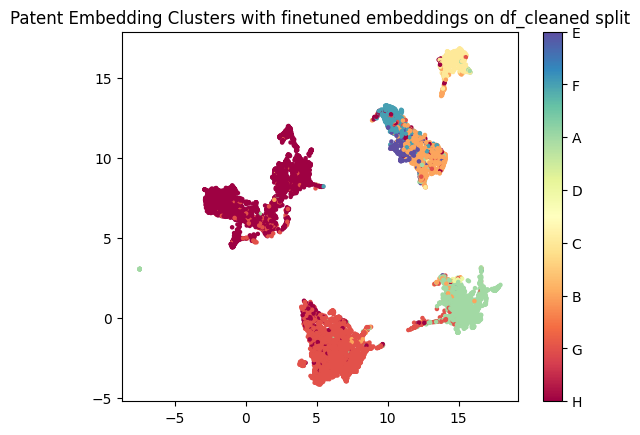

In [19]:
import umap
import matplotlib.pyplot as plt

valid_sections = list("ABCDEFGHY")
df_cleaned_tmp = df_cleaned[df_cleaned["section"].isin(valid_sections)]

reducer = umap.UMAP(n_neighbors=15, random_state=42)
# Compute UMAP projection only on embeddings corresponding to df_cleaned
proj = reducer.fit_transform(embeddings[df_cleaned_tmp.index])

# Define labels for coloring the scatter plot
labels = df_cleaned_tmp["section"]

# Map string labels to numerical values
unique_labels = labels.unique()
label_map = {label: i for i, label in enumerate(unique_labels)}
numerical_labels = labels.map(label_map)


plt.scatter(proj[:,0], proj[:,1], c=numerical_labels, cmap='Spectral', s=5)
plt.title("Patent Embedding Clusters with finetuned embeddings on df_cleaned split")
# Add a colorbar to show the mapping of colors to sections
cbar = plt.colorbar(ticks=np.arange(len(unique_labels)))
cbar.ax.set_yticklabels(unique_labels)
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report

embeddings = embedder.encode(test_df["combined_text"].tolist())

# Split section into list (if it's a comma-separated string)
test_df['section_list'] = test_df['section'].apply(lambda x: x.split(',') if isinstance(x, str) else [])

# Binarize multi-label output
mlb = MultiLabelBinarizer(classes=["A", "B", "C", "D", "E", "F", "G", "H", "Y"])
Y = mlb.fit_transform(test_df["section_list"])


# Step 2: Train-test split
# Since embeddings were created from df_cleaned (after the initial split and dropping missing sections),
# we can use the index of this df_cleaned directly as it corresponds to the embeddings.
X_train, X_test, y_train, y_test = train_test_split(
    embeddings, Y, test_size=0.5, random_state=42
)

# Step 3: Train a One-vs-Rest classifier
clf = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
clf.fit(X_train, y_train)

# Step 4: Predict and evaluate
y_pred = clf.predict(X_test)
print("Multi-label Section Classification Report (OneVsRestClassifier) on test_df split with finetuned embeddings:\n")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Multi-label Section Classification Report (OneVsRestClassifier) on test_df split with finetuned embeddings:

              precision    recall  f1-score   support

           A       0.88      0.79      0.83       314
           B       0.75      0.55      0.64       314
           C       0.84      0.73      0.78       186
           D       0.00      0.00      0.00        19
           E       0.81      0.35      0.49        49
           F       0.78      0.48      0.59       109
           G       0.78      0.76      0.77       599
           H       0.85      0.80      0.82       634
           Y       0.00      0.00      0.00        18

   micro avg       0.82      0.71      0.76      2242
   macro avg       0.63      0.49      0.55      2242
weighted avg       0.80      0.71      0.75      2242
 samples avg       0.82      0.77      0.77      2242



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [21]:
# Use a logistic regression based classifier
from sklearn.linear_model import LogisticRegression

clf = OneVsRestClassifier(LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    solver='lbfgs'
))
clf.fit(X_train, y_train)

# ------------------------------------------------
# STEP 5: Predict & Evaluate
# ------------------------------------------------

y_pred = clf.predict(X_test)


# Classification report
print("Multi-label LogisticRegression Section Classification Report on test_df split with finetuned embeddings:")
print(classification_report(y_test, y_pred, target_names=mlb.classes_))


Multi-label LogisticRegression Section Classification Report on test_df split with finetuned embeddings:
              precision    recall  f1-score   support

           A       0.78      0.86      0.82       314
           B       0.53      0.79      0.64       314
           C       0.64      0.90      0.75       186
           D       0.07      0.74      0.12        19
           E       0.16      0.84      0.26        49
           F       0.33      0.88      0.48       109
           G       0.79      0.76      0.78       599
           H       0.84      0.82      0.83       634
           Y       0.01      0.11      0.01        18

   micro avg       0.54      0.81      0.65      2242
   macro avg       0.46      0.74      0.52      2242
weighted avg       0.71      0.81      0.74      2242
 samples avg       0.70      0.86      0.72      2242

